<a href="https://colab.research.google.com/github/AndresNamm/nn_zero_to_hero/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTUITION

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

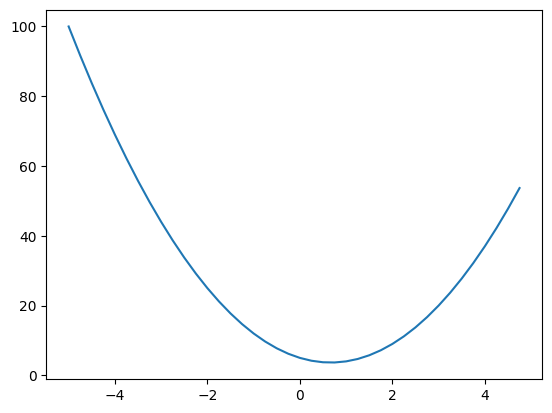

In [5]:
xs = np.arange(-5,5,0.25)
ys = f(xs)

plot=plt.plot(xs,ys)


# DERIVATIVE OF FUNCTION

$$\frac{dy}{dx}=lim_{h->
0}\frac{f(x+h)-f(x)}{h}$$

In [6]:
h=0.0001
x=3.0
dfdx = ((f(x+h)-f(x))/h)
print(dfdx)

14.000300000063248


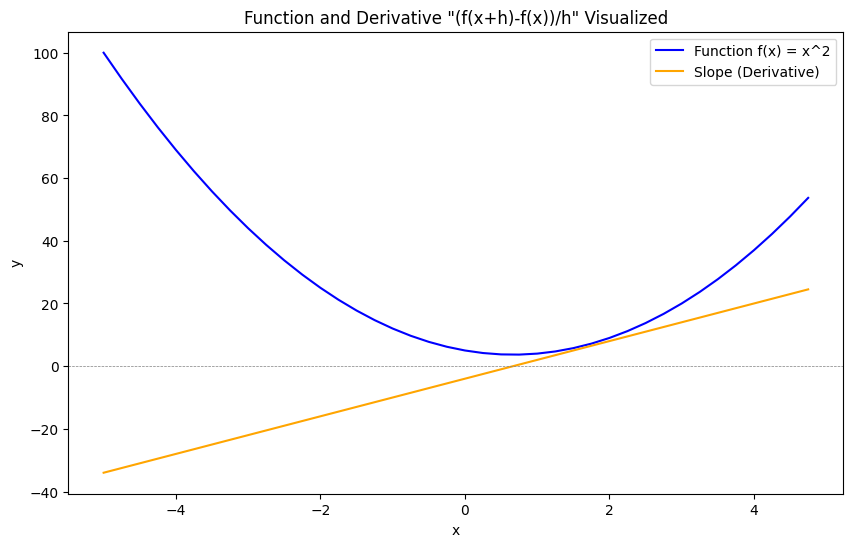

In [8]:
def slope(x,h=0.0001):
    return ((f(x+h)-f(x))/h)


xs = np.arange(-5,5,0.25)
ys = slope(xs)

ys_function = f(xs)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the function f(x)
plt.plot(xs, ys_function, label="Function f(x) = x^2", color="blue")

# Plot the slope (numerical derivative)
plt.plot(xs, ys, label="Slope (Derivative)", color="orange")

# Add title and labels
plt.title('Function and Derivative "(f(x+h)-f(x))/h" Visualized')
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color="gray", linewidth=0.5, linestyle="--")  # Add a horizontal line at y=0

# Add a legend
plt.legend()

# Display the plot
plt.show()

# MICROGRAD FRAMEWORK

Micrograd is a tiny yet powerful framework that mimics how larger machine learning libraries (like PyTorch) handle automatic differentiation. It provides an intuitive way to explore the nuances of gradient calculations.

+ Each value in MicroGrad is generated by 2 previous values and Operation that takes place between them (Similiar to Algebra actually). This approach allows to create an automatic derivative calculation function (backward) for each operation between two binary values.
+ Note on naming: In the init of Value object we are calling the predecessors of a value its children. There could be argument to say that instead the Value itself is a child to its predecessors. However if we look at this like a tree, we can also say the predecessors are Value's children (Current Approach)

In [7]:
class Value:

    def __init__(self,data, _children=(), _op='',label=''):

        # One question, I had is why in the context of building values we name the predecessor values children. In some logic these instead could be called parents
        # This is true, but the result of micrograd, specially when calculating derivatives starts from the last value. In this way, the result looks like a tree starting from
        # The output value.
        self.data:float = data
        self.grad:float = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._gradient_updates=0

    def __repr__(self):
        return f"Value(data={self.data})"

    def get_node_label(self):

            label = f"{self.label}={self.data}" if self.label else self.data
            return "{" + f"{label} | grad={self.grad}" + " | " + f"grad_updates={self._gradient_updates}" + "}"

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out =  Value(self.data + other.data, {self,other}, _op='+')

        def _backward(): # This backward function is called from the out variable, if affects the gradients for both of its predecessors.
        # aka the result value , however the _backward function assigns gradients to input variables leveraging its own gradient #
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
            self._gradient_updates+=1
            other._gradient_updates+=1
        out._backward = _backward

        return out

    def __radd__(self,other):# https://stackoverflow.com/questions/9126766/addition-between-classes-using-radd-method
        return self+other

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, {self,other}, _op='*')

        def _backward():
            # We are adding to gradient because the value could have effect
            # through multiple later stages.
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            self._gradient_updates+=1
            other._gradient_updates+=1

        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float))

        out = Value(self.data**other,{self,},_op=f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
            self._gradient_updates+=1

        out._backward = _backward

        return out

    def __neg__(self):
        return self * (-1)

    def __sub__(self,other):
        return self + (-other)

    def __truediv__(self,other):
        return self * other**-1

    def __rmul__(self,other): # https://stackoverflow.com/questions/5181320/under-what-circumstances-are-rmul-called
        return self * other

    def tanh(self): # https://wikimedia.org/api/rest_v1/media/math/render/svg/b8dc4c309a551cafc2ce5c883c924ecd87664b0f
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
            self._gradient_updates+=1

        out._backward = _backward
        return out

    def exp(self):
        x=self.data
        out = Value(math.exp(x), (self,),'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
            self._gradient_updates+=1

        out._backward=_backward
        return out


    def backward(self): # This function is called on the final outcome of all the operations (substraction,multiplication..)
        # Implemented depth first search that tracks visited nodes.
        # It starts from root node (final result ) and runs recursively build_topo function for each node in hierarcy.
        # The build_topo function finishes last for the root node so its added last to topo array.

        visited=set()
        topo=[]
        def build_topo(o):
            if o not in visited:
                visited.add(o)
                for node in o._prev:
                    build_topo(node)
                topo.append(o)
        self.grad=1
        build_topo(self)
        for node in reversed(topo): # Reversed makes sure that backward function starts from the last Value calculated (the result)
        # This ensures, each predecessor total gradient is calculated only after its successor gradient values have been generated
        # This is important because each values gradient is impacted by the impact it has on the successor values
            node._backward()




a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e=a*b; e.label = 'e'
d=e+c; d.label = 'd'
f= Value(-2.0,label='f')
L = d*f; L.label = 'L'

L


Value(data=-8.0)

In [ ]:
d

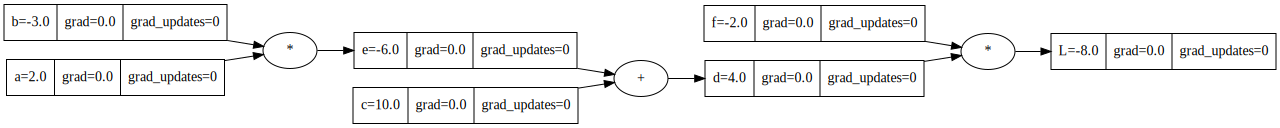

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph. Runs a DFS from the answer to all the components
  # that contributed to it.
  nodes, edges = set(), set()
  def build(v): #  DFS
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


# Draws out all nodes and edges from set
# Adds operations as well to the picture
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    #dot.node(name = uid, label = "{ %s | data %.4f |  }" % ( n.label ,n.data), shape='record')
    dot.node(name = uid, label = n.get_node_label(), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(L)

**NB** The thing to note about this Value based calculation implementation is that here we are doing every calculation pairwise.
This allows us to very easily define partial derivatives for each result of pairwise operation.

# DOING GRADIENT CALCULATIONS IN NN EXAMPLE

In [9]:

def initialize_global_weights():
    global x1, x2, w1, w2, b, x1w1, x2w2, x1w1x2w2, n, o
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    o = n.tanh(); o.label = 'o'
initialize_global_weights()

# EXAMPLE - FINDING MANUAL GRADIENTS FOR EACH PARAMETER FOR FUNCTION O()

In this example, we could imagine O is some kind of Cost function.

- leveraging [chain rule](https://www.notion.so/dataleaper/Chain-Rule-6ffc28788e9a46dc8f770dde793fda39?pvs=4)

In [10]:
o.grad = 1.0 # dO/dO = 1
# o = tanh(n)
# dO/dn = 1.0 - tanh(n)**2 = 1 - o**2
n.grad = (1.0  - o.data**2) # derivative in o.data location
# need to leverage chain rule here to find dO/dw1
# dO/db = dO/Dn * dN/db
# dN/db = 1 -> derivative on b inside a sum is 1 -- https://www.mathsisfun.com/calculus/derivatives-rules.html
b.grad = (1) * n.grad
# dO/dx1w1x2w2 = dO/dn * dN/dx1w1x2w2
# dN/dx1w1x2w2 -> derivative of x1w1x2w2 inside function b + x1w1x2w2 is 1
x1w1x2w2.grad = (1) * n.grad
# dO/x1w1 = dO/dx1w1x2w2 * dX1W1X2W2/x1w1 #
# dX1W1X2W2/x1w1 -> derivative of x1w1 inside sum is 1
x1w1.grad = (1) * x1w1x2w2.grad
# dO/x2w2 = dO/dx1w1x2w2*dX1W1X2W2/x2w2#
# dX1W1X2W2/x2w2 -> derivative of x2w2 inside sum is 1
x2w2.grad = (1) * x1w1x2w2.grad
# d0/w1 = dO/x1w1 * dX1W1/dw1
# dX1W1/dw1 = x1
w1.grad =  (x1.data) * x1w1.grad
# d0/w2 = dO/x2w2 * dX2W2/dw2
# dX2W2/dw2 = x2
w2.grad = (x2.data) * n.grad
# dO/dx1 = dO/x1w1 * dX1W1/dx1
# dX1W1/dx1 = w1
x1.grad = (w1.data) * x1w1.grad
# dO/dx2 = dO/x2w2 * dX2W2/dx2
# dX2W2/dx2 = w2
x2.grad = (w2.data) * x2w2.grad


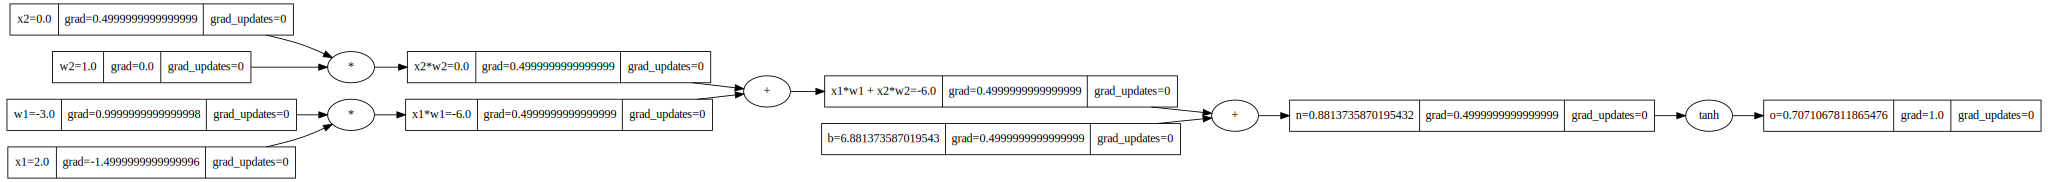

In [11]:
draw_dot(o)

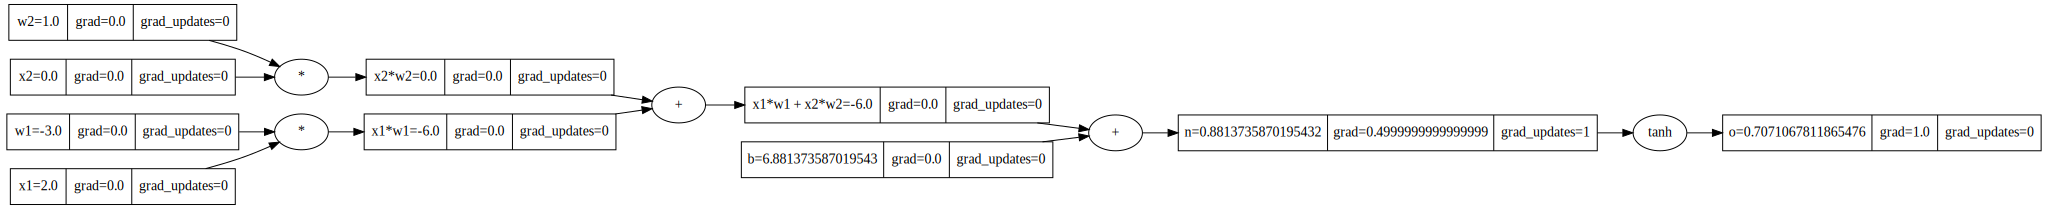

In [12]:
initialize_global_weights()
o.grad = 1.0
o._backward()
draw_dot(o) # Calculates the gradients for the input value.


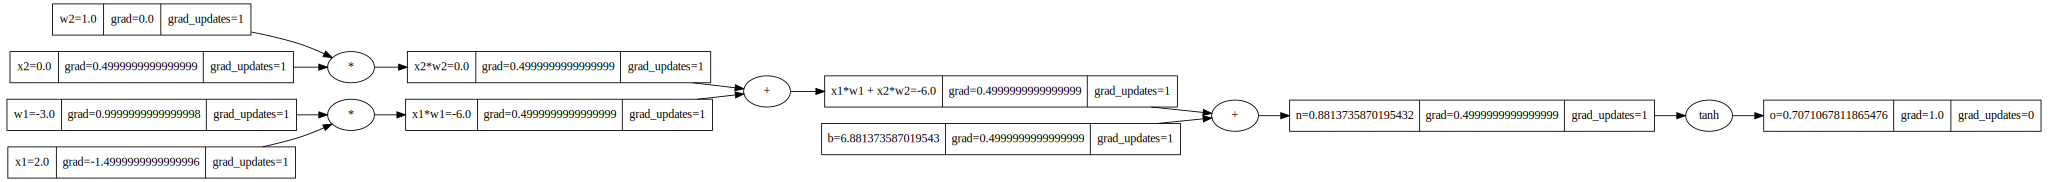

In [13]:

n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
w2._backward()
x1._backward()
x2._backward()
draw_dot(o)


# QUESTION TIME

## QUESTION  


- Why is the gradient the best direction to go when optimizing cost function?



## ANSWER

- In this case, we have first found out the partial derivative for each input variable in regards to the cost function (scalar value)
- These partial derivatives tell us the slope on each variables side.
- We are looking for the greatest combination of moving on the slopes of these parameters, e.g highest downward direction magnitude wise in regards to the cost function
- We can now think of something like choosing the best directional derivative $argmax(lim_{k->0} k \vec{x}\frac{df}{dv},\vec{x})$ where $\vec{x}$ is an unit vector in certain direction.
- The directional derivative is a dot product between vector of partial derivatives and directional vector. As $\vec{x}$ is unit vector the dot product is also a projection to the vector x. What achieves the highest projection? If two vectors move in the same direction. Aka gradient moves in the same direction as vector of partial derivatives.   
- Read more this https://www.notion.so/dataleaper/CALCULUS-course-d74f76e4fead433a913704a584b57c79?pvs=4#cd55aaccf80d4654b731c4338e7aadff


# IMPLEMENTING BACKPROPAGATION WITH TOPOLOGICAL SORT

We use topological sort to implement backpropagation

1. We maintain list of visited nodes as there are many ways in NN we can get from to a certain node.
2. We get topological sort with reverse DFS as it guarantees that the parent always is called before its children

**NB - implemementation is done within Value class in backward function**. I have added a lot of comments there.

![](https://matthewmazur.files.wordpress.com/2018/03/neural_network-9.png)



I added this picture here to explain why in neural network there is possibility to go to children not many times from root node:

In [14]:
o.backward()

# BUGFIX

- Gradients are overwritten if one variable occurs as a dependency to multiple later variables (Like in regular NN)
- https://youtu.be/VMj-3S1tku0?si=iaHDwg_ni1FrIEJd&t=5145
- Solution: Use +=  to gradient when backwards function is called.



# OPENING OUT TANGENT

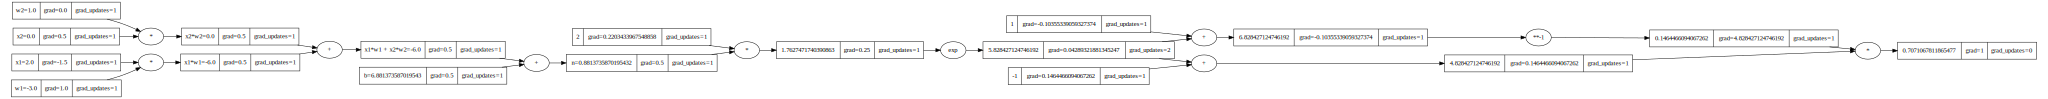

In [15]:
def initialize_global_weights_v2():
    global x1, x2, w1, w2, b, x1w1, x2w2, x1w1x2w2, n, o
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    # ----
    # o = n.tanh(); o.label = 'o'
    # instead we are going to do
    e = (2*n).exp()
    o = (e-1)/(e+1)


initialize_global_weights_v2()

o.backward()
draw_dot(o)

# DOING THE SAME THING BUT IN PYTHORCH

In [16]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad=True
n = x1*w1+x2*w2+b
o = torch.tanh(n)


o.backward()

print(o.data.item())

print('----')
print(f'x1: {x1.grad.item()}')
print(f'w1: {w1.grad.item()}')
print(f'x2: {x2.grad.item()}')
print(f'w2: {w2.grad.item()}')

0.7071066904050358
----
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0


# LETS START WITH BUILDING OUT A NEURAL NET

<class '__main__.Value'>
Value(data=0.5437194218987713)


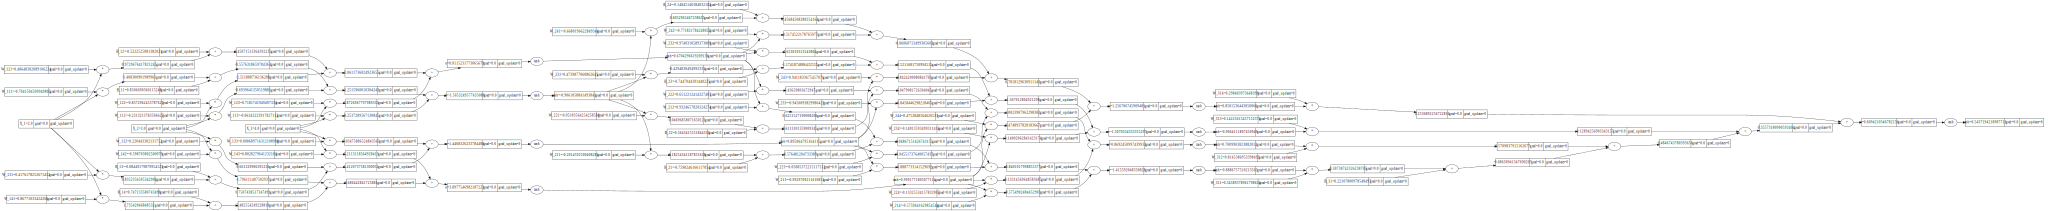

In [17]:
import random

class Neuron:
    def __init__(self,nin,layer_idx,neuron_idx):
        self.w = [Value(random.uniform(-1, 1),label=f'W_{layer_idx}{neuron_idx}{parameter_idx+1}') for parameter_idx in range(nin)]
        self.b = Value(random.uniform(-1,1),label=f'B_{layer_idx}{neuron_idx}')

    def __call__(self,x): # Returns scalar value between -1 and 1
        n = sum((xi*wi for xi,wi in zip(x,self.w)),self.b); n.label = 'n'
        tan = n.tanh(); tan.label = 'tanh'
        return tan

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout, layer_idx): # Input is how many inputs each neuron takes. It's the number of dimensions in
        # n-1 layer, output is how many neurons will be generated.
        self.neurons = []
        for neuron_idx in range(nout):
            self.neurons.append(Neuron(nin,layer_idx,neuron_idx+1))

    def __call__(self,x):
        out = []
        for neuron in self.neurons:
            out.append(neuron(x))

        return out[0] if len(out)==1 else out

    def parameters(self):
        return [parameter for neuron in self.neurons for parameter in neuron.parameters() ]#

class MLP:
    def __init__(self, nin, layers):
        sz = [nin]+layers
        self.layers = []
        for i in range(1, len(sz)): # generate neurons for each layer. We start from 1 not 0 index because the 0th index describes size of data not neural network layer. It's needed to determine firs layer neuron size.
            # Each neuron in layer sz[i-1] inputs
            # Each layer has sz[i] neurons
            self.layers.append(Layer(sz[i-1],sz[i],i))


    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]#

x = [2.0,3.0,4.0]
x = [Value(x,label=f"X_{idx+1}") for idx, x in enumerate(x)]
neural_network = MLP(3,[4,4,1])
# first layer has 4 neurons each with input size of 3
# second layer has also 4 neurons each with input size of 4
# third layer has 1 neuron with input size of 4

res = neural_network(x)

print(type(res))
print(res)

draw_dot(neural_network(x))


# BACKPRPOPAGATION WITH GRADIENT DESCENT

Okay, so now we have created a neural network. It is finally time to start optimizing it.     
Optimize it for what? that is a good question. We have nothing to optimize to in this specific moment.

1. To optimize it, we need to define **training data**. And a cost function. In our example this will be multiple pairs of x and y, where x is n valued vector and y is a scalar that we want to predict based on x.
2. Next we will define cost function on top of neural network that summarizes how much NN forward pass output on top of x deviates from y.
3. Then we will define gradients for all w-s in regards to that cost function and substract gradient * learning_rate from the original w values.
    + In short, as gradient is just a collection of partial derivatives. As a whole it gives us the direction of function parameter movements in the steepest ascent. Opposite to that gives us the deepest descent. [Explanation](https://www.notion.so/dataleaper/CALCULUS-course-d74f76e4fead433a913704a584b57c79?pvs=4#be62339628e04a8fbf7cbe3dadc83174)
    + Thus moving that will give us the deepest cost reduction


For the cost function we do forward propagation with data multiple times, then we compare the result with real y and sum the differences up.

We now try to move NN params in direction so that cost function would go down. To do this we call backward on cost function.

If we have n training pairs, each parameter (w or b) has been used n times directly to get some calculation result.
** Recall that each parameter is used only within 1 neuron as multiplicator for particular input.


**NB** Important thing to take into account


- With the recursive backward methodology we are using we will calculate first parent derivatives and then child derivatives.
For child $$w_i$$, the derivative will be calculated only directly to $$\frac{dw_i}{dh}$$ and then multiplied with the total dh derivative.
It has only 1 parent thus only 1 backward call. However, $$w_i$$ will still have effect throuhgh multiple parents.
- The end result cos function is based on somethin like a sum for all training pairs. Thus with each training example we are adding to the cost function which meand for each training example we will also to backpropgataion       




# ONE TRAINING EXAMPLE

https://www.youtube.com/watch?v=KUw20-24YNE&t=124s&ab_channel=AndresNamm  -- video explaining backwards call amount.

After 1 forward pass 1

In [18]:
x= [
    [Value(2.0,label='X_11'),Value(3.0,label='X_12'),Value(4.0,label='X_13')],
]

y = [Value(1.0,label='Y')]

neural_network = MLP(3,[4,4,1])


y_pred = [neural_network(x_i) for x_i in x] #
cost:Value = sum((y_pred_i-y_i)**2 for y_i, y_pred_i in zip(y,y_pred))# type: ignore #


print(cost)



Value(data=0.49809625479510256)


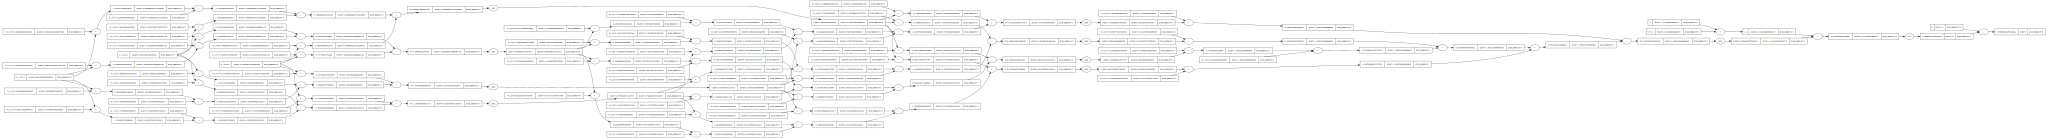

In [19]:
cost.backward()
draw_dot(cost)


# MULTIPLE TRAINING EXAMPLES

Here w.grad is updated from 2 different n-s

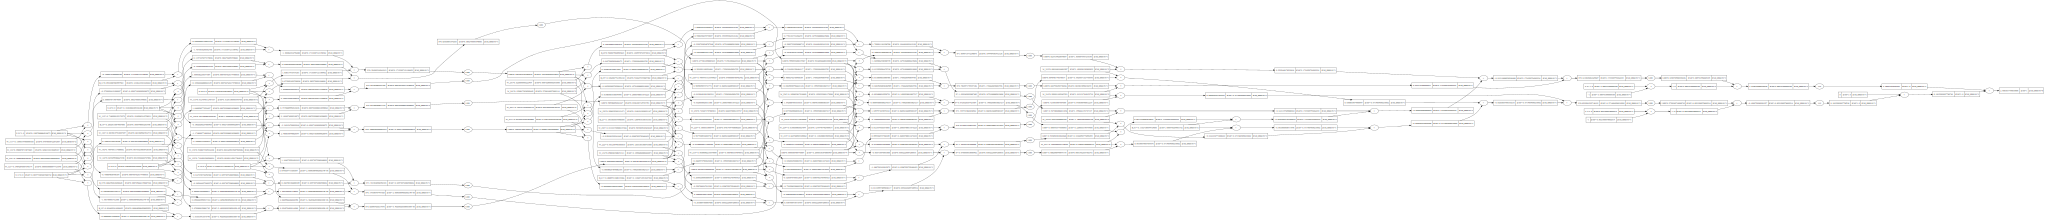

In [20]:

x= [
    [2.0,3.0,4.0],
    [1.0,2.0,3.0]
]

x = [[Value(xi,label=f'X{idx_i+1}{idxi+1}') for idxi,xi in enumerate(x_i)] for idx_i, x_i in enumerate(x)]


y = [1.0,-1.0]
y = [Value(yi,label=f'Y{idx+1}') for idx,yi in enumerate(y)]


neural_network = MLP(3,[4,4,1])

y_pred = [neural_network(x_i) for x_i in x] #
cost:Value = sum((y_pred_i-y_i)**2 for y_i, y_pred_i in zip(y,y_pred))# type: ignore #

cost.backward()
draw_dot(cost)

# MATHEMATICAL (KINDA) EXPLANATION

![](https://github.com/AndresNamm/nn_zero_to_hero/blob/main/data/img/training_example_derivative.png?raw=1)


- For example the derivative for ${w_{11}}$ in regards to cost function is based on the derivative sum rule (among other things) where derivatives from $NN(x_{ij})-y_{ij}$ all sum up to get final derivative of $w_{ij}$'
- With each training pair we are going through, we will do additional backpropagation. That means we will update gradient based on each training example forward pass

# IMPLEMENTING BACKPROPAGATION

In [21]:
def backpropagation(nn: MLP, x, y, trainig_rate, iterations=100):

    for i in range(iterations):
        # With each training pair we are going through, we will do 1 forward pass of the network
        y_pred=[nn(xi) for xi in x]

        # We add up the total cost. With the current approach this total cost will be the weights multiplied with
        # with all forward passes and compared with real training data. For each forward paas the cost function becomes this
        # Giant calculation #
        cost: Value =  sum([(y_i-y_pred_i)**2 for y_i,y_pred_i in zip(y_pred,y)]) # type: ignore

        for param in nn.parameters():
            param.grad=0.0

        # Calculate gradient for neural network parameters w-s and b-s
        cost.backward()

        #print(",".join([f"{param.label}={param.data}" for param in all_params]))
        for param in nn.parameters():
            param.data -= trainig_rate*param.grad

        print(cost)



nn = MLP(3,[4,4,1])

x= [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

x = [[Value(xi,label=f'X{idx_i+1}{idxi+1}') for idxi,xi in enumerate(x_i)] for idx_i, x_i in enumerate(x)]


y = [1.0, -1.0, -1.0, 1.0]
y = [Value(yi,label=f'Y{idx+1}') for idx,yi in enumerate(y)]

# You can try different params here
neural_network = MLP(3,[100,100,1])


backpropagation(neural_network,x,y,0.1,20)

Value(data=5.88962582543049)
Value(data=7.999999970601165)
Value(data=7.9999999706009834)
Value(data=7.9999999706008005)
Value(data=7.9999999706006175)
Value(data=7.999999970600436)
Value(data=7.999999970600253)
Value(data=7.99999997060007)
Value(data=7.999999970599889)
Value(data=7.999999970599706)
Value(data=7.999999970599523)
Value(data=7.999999970599342)
Value(data=7.999999970599159)
Value(data=7.999999970598976)
Value(data=7.999999970598795)
Value(data=7.999999970598612)
Value(data=7.999999970598429)
Value(data=7.999999970598248)
Value(data=7.999999970598065)
Value(data=7.999999970597882)


In [22]:
print(neural_network(x[0]))

Value(data=-0.9999999999991406)


In [23]:
print(neural_network(x[1]))

Value(data=-0.9999999991946636)
